# Automatic Panorama Mosaicing

#### Proof of parallelism after affine transformation.

$Proof$:

We can represent any affine transformation by a homogeneous matrix $A_h$, where 
$A_h=\begin{bmatrix}
a & b & c \\
d & e & f \\
0 & 0 & 1
\end{bmatrix}
\quad$

For any input homogeneous vector $\vec{x_h}=\begin{bmatrix}
x \\
y \\
1
\end{bmatrix}$, the output after affine transformation will be $A_h \vec{x_h}$.

Alternatively, we may rewrite such transformation in Cartesian form: $A\vec{x}+\vec{b}$, where 
$A=\begin{bmatrix}
a & b \\
d & e
\end{bmatrix},
\vec{b}=\begin{bmatrix}
c \\
f
\end{bmatrix},
\vec{x}=\begin{bmatrix}
x \\
y \\
\end{bmatrix}$

Suppose we have a line $\vec{l_1}$ defined as $\vec{i_1}+\lambda\vec{g_1}$, where 
$\vec{i_1}=\begin{bmatrix}
i_{1x} \\
i_{1y}
\end{bmatrix}$ represents the interaction of $\vec{l_1}$, 
$\vec{g_1}=\begin{bmatrix}
g_{1x} \\
g_{1y}
\end{bmatrix}$ represents the gradient of $\vec{l_1}$.

For any line $\vec{l_2}$ parallel to $\vec{l_1}$, we will has its form: $\vec{l_2}=\vec{i_2}+\lambda (k\vec{g_1})$, where
$\vec{i_1}=\begin{bmatrix}
i_{2x} \\
i_{2y}
\end{bmatrix}$ represents the interaction of $\vec{l_2}$, and $k\in \mathbb{R}$.

$f(\vec{l_1})=A\vec{l_1}+\vec{b}=A\vec{i_1}+\lambda A\vec{g_1}+\vec{b}=(\vec{i_1'}+\vec{b})+\lambda\vec{g_1'}$

$f(\vec{l_2})=A\vec{l_2}+\vec{b}=A\vec{i_2}+\lambda k A\vec{g_1}+\vec{b}=(\vec{i_2'}+\vec{b})+\lambda (k\vec{g_1'})$

After affine transformation, line $f(\vec{l_2})$ is parallel to line $f(\vec{l_1})$.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, ProjectiveTransform
from skimage.color import rgb2gray
from skimage.measure import ransac

## Feature Extraction and Feature Matching

#### Apply Harris Corners for feature detection and BRIEF Descriptor for feature matching.

the number of matches is 53


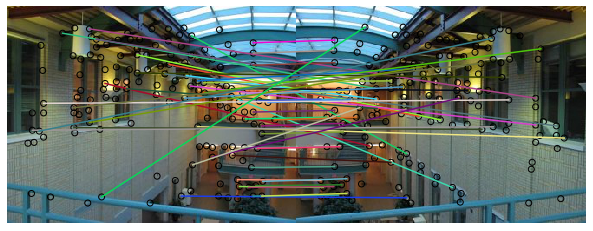

In [8]:
imL = image.imread("images/CMU_left.jpg")
imR = image.imread("images/CMU_right.jpg")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
keypointsL = corner_peaks(corner_harris(imLgray), threshold_rel=0.0005, min_distance=5)
keypointsR = corner_peaks(corner_harris(imRgray), threshold_rel=0.0005, min_distance=5)

extractor = BRIEF()

extractor.extract(imLgray, keypointsL)
keypointsL = keypointsL[extractor.mask]         
descriptorsL = extractor.descriptors

extractor.extract(imRgray, keypointsR)
keypointsR = keypointsR[extractor.mask]
descriptorsR = extractor.descriptors

matchesLR = match_descriptors(descriptorsL, descriptorsR, cross_check=True)

print ('the number of matches is {:2d}'.format(matchesLR.shape[0]))

fig = plt.figure(1,figsize = (12, 4))
axA = plt.subplot(111)
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')

plt.show()

#### There are $N=53$ matches $(p,p')$ as in the figure above.  Suppose $N_i=21$ of these matches are inliers for a homography, while the rest of the matches are $N_o=32$ outliers. To estimate a homography we need a sample with $K=4$ matches. The below cell derive and estimate the least number of times one should randomly sample a subset of $K$ matches to get probability  $p≥0.95$  that at least one of these samples has all of its $K$ matches from inliers.

$Derivation$:

The least number of times to sample at least one random sample of 4 inliers with probability $p\geq 0.95$ is equivalent to the most number of times to sample random pairs that always include at least one outlier with probability $p> 0.05$ plus one.

At each round, the probability to sample a random pair of inliers (sampling without replacement)
$$p_{allInliers}=\frac{N_i \choose 4}{N_i+N_o \choose 4}=\frac{N_i(N_i-1)(N_i-2)(N_i-3)}{(N_i+N_o)(N_i+N_o-1)(N_i+N_o-2)(N_i+N_o-3)}$$
$$p_{\neg allInliers}=1-p_{allInliers}=1-\frac{N_i(N_i-1)(N_i-2)(N_i-3)}{(N_i+N_o)(N_i+N_o-1)(N_i+N_o-2)(N_i+N_o-3)}$$

$$p_{\neg allInliers}^{k-1} > 0.05,k\in\mathbb{Z}^+$$

$$k < \frac{\ln(0.05)}{\ln(p_{\neg allInliers})}+1$$

$Numerical\:Solution$:

$$N_i=21, N_o=32$$

$$p_{\neg bothInliers}=1-\frac{21\times20\times19\times18}{53\times52\times51\times50}=\frac{57368}{58565}$$

$$k < \frac{\ln(0.05)}{\ln(\frac{57368}{58565})}+1$$

$$k < 146.07, k=146$$

Therefore, the least number of times to sample at least one random pair of inliers with probability $p\geq 0.95$ is $146$.

#### The code below uses RANSAC to find matched pairs of inliers above. 

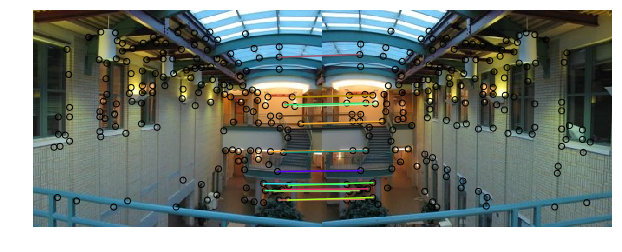

In [377]:
data = (keypointsL[matchesLR[:,0]][:,[1,0]], keypointsR[matchesLR[:,1]][:,[1,0]])
model_robust, inliers = ransac(data, ProjectiveTransform, min_samples=4, residual_threshold=2, max_trials=146)

fig = plt.figure(2,figsize = (12, 4))
axA = plt.subplot(111)
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR[inliers]) #, matches_color = 'r')
axA.axis('off')

plt.show()

## Reprojection

#### Use the plane of the left image as the common PP. The pamorama mosaic is built inside a "reference frame" inside this common PP. The reference frame is big enough to contain the left image and the part of the view covered by the right image after reprojecting onto common PP.
#### The first reference frame contains the left image only. 
#### The second reference frame shows the reprojected right image using only inlier matches.
#### For comparison purposes, the third reference frame demonstrates the reprojected right image using all matches.
#### Note: function $warp$ needs "inverse map" as its 2nd argument (left to right).

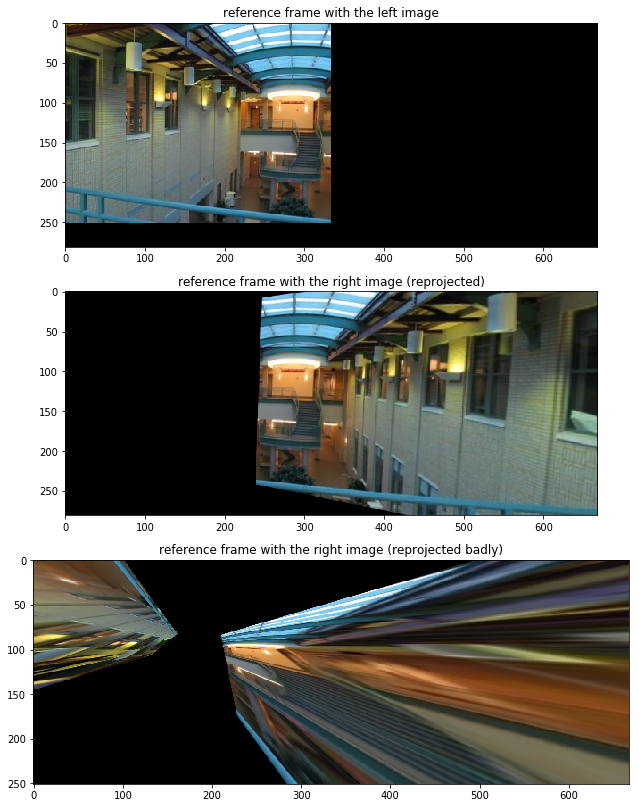

In [378]:
fig = plt.figure(3,figsize = (12, 14))
plt.subplot(311)
imL_ref = np.hstack((imL, np.zeros(imR.shape)))
imL_ref = np.vstack((imL_ref, np.zeros((30, imL_ref.shape[1], imL_ref.shape[2])))).astype(np.uint8)
plt.imshow(imL_ref)
plt.title("reference frame with the left image")

plt.subplot(312)
imR_ref = np.hstack((imR, np.zeros(imR.shape)))
imR_ref = np.vstack((imR_ref, np.zeros((30, imR_ref.shape[1], imR_ref.shape[2])))).astype(np.+)
imR_ref = warp(imR_ref.astype(np.uint8), model_robust)
plt.imshow(imR_ref)
plt.title("reference frame with the right image (reprojected)")

plt.subplot(313)
pt = ProjectiveTransform()
pt.estimate(data[0], data[1]) # warp() needs "inverse map"
plt.imshow(warp(imR_, pt))
plt.title("reference frame with the right image (reprojected badly)")

plt.show()

## Blending

#### The function below computes the distance transform for the boundary of a given image. It returns a numpy array of the same size as the image with distances from each pixel to the closest point on the boundary of the image (float values). 

In [379]:
def boundaryDT(image):
    dt = np.empty(image.shape[:2])
    row, col = image.shape[:2]
    for i in range(row):
        for j in range(col):
            dt[i][j] = min(i, j, row-i-1, col-j-1)
    return dt / np.max(dt)

#### Apply boundaryDT function to compute distance transforms for both images. 

Text(0.5,1,'Right image DT in Ref. frame (RdtRef)')

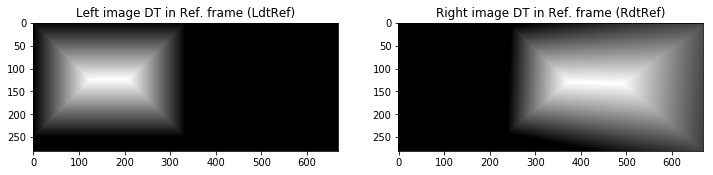

In [383]:
fig = plt.figure(4,figsize = (12, 3))
plt.subplot(121)
plt.title("Left image DT in Ref. frame (LdtRef)")
imL_dt = boundaryDT(imL)
imL_dt_ref = np.hstack((imL_dt, np.zeros(imL_dt.shape)))
imL_dt_ref = np.vstack((imL_dt_ref, np.zeros((30, imL_dt_ref.shape[1]))))
plt.imshow(imL_dt_ref)

plt.subplot(122)
imR_dt = boundaryDT(imL)
imR_dt_ref = np.hstack((imR_dt, np.zeros(imR_dt.shape)))
imR_dt_ref = np.vstack((imR_dt_ref, np.zeros((30, imR_dt_ref.shape[1]))))
imR_dt_ref = warp(imR_dt_ref, model_robust)
plt.imshow(imR_dt_ref)
plt.title("Right image DT in Ref. frame (RdtRef)")

#### Use boundary distance transforms to blend left and reprojected right images into the reference frame. The first and second figures are $alpha$'s for blending the left and right images. These $alphas$ are based on distance transforms. The third figure is the final panorama with reprojected features (homography inliers) from both left and right images.

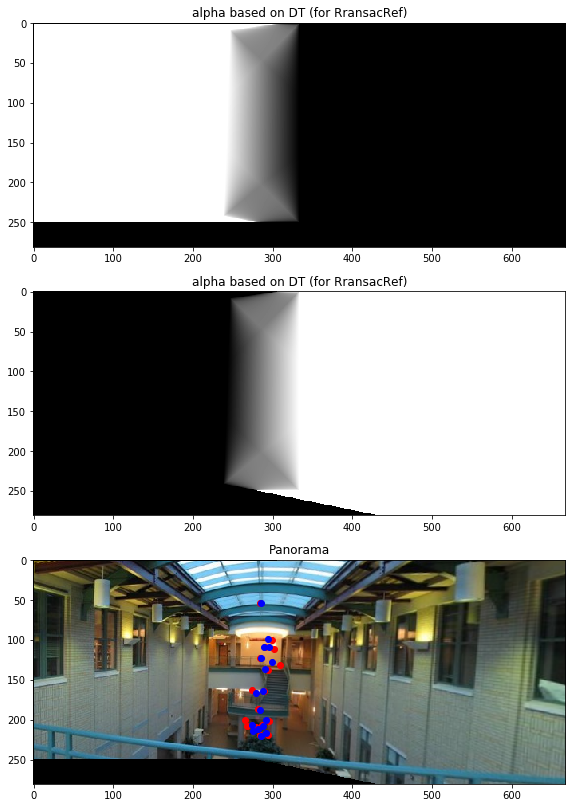

In [384]:
import numpy.linalg as la

fig = plt.figure(5,figsize = (12, 14))
plt.subplot(311)
epsilon = 1e-10
imL_alpha = imL_dt_ref / (imL_dt_ref + imR_dt_ref + epsilon)
plt.imshow(imL_alpha)
plt.title("alpha based on DT (for RransacRef)")

plt.subplot(312)
imR_alpha = imR_dt_ref / (imL_dt_ref + imR_dt_ref + epsilon)
plt.imshow(imR_alpha)
plt.title("alpha based on DT (for RransacRef)")

plt.subplot(313)

imL_alpha_color = np.empty((imL_alpha.shape[0], imL_alpha.shape[1], 3))
imR_alpha_color = np.empty((imR_alpha.shape[0], imR_alpha.shape[1], 3))
for i in range(imL_alpha.shape[0]):
    for j in range(imL_alpha.shape[1]):
        imL_alpha_color[i][j] = [imL_alpha[i][j]]*3
        imR_alpha_color[i][j] = [imR_alpha[i][j]]*3
        
plt.imshow(imL_alpha_color*imL_ref/255 + imR_alpha_color*imR_ref)

plt.scatter(keypointsL[matchesLR[:,0]][:,[1,0]][inliers][:,0], keypointsL[matchesLR[:,0]][:,[1,0]][inliers][:,1], c='r')
tf_inv = la.inv(model_robust.params)
imR_inlier = keypointsR[matchesLR[:,1]][:,[1,0]][inliers]
imR_inlier_h = np.hstack((imR_inlier, np.ones((imR_inlier.shape[0],1))))
imR_inlier_tf = (tf_inv @ imR_inlier_h.T).T[:,:2]
plt.scatter(imR_inlier_tf[:,0], imR_inlier_tf[:,1], c='b')
plt.title("Panorama")

plt.show()